# Formas de representação de grafos

ECOM033 - Teoria dos grafos

Professor Glauber R. Leite

## Implementação "Naive"

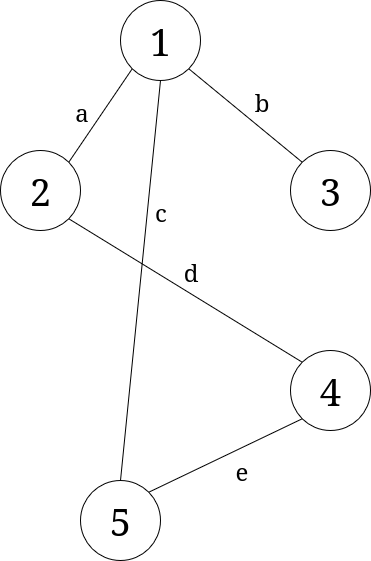

In [36]:
V = {1,2,3,4,5}
E = {(1,2), (1,3), (1,5), (2,4), (4,5)}

def isNeighbor(v, w, directed: bool = False):
  for e in E:
    v1, v2 = e
    if (v1 == v and v2 == w) or (not directed and v1 == w and v2 == v) :
      return True
  return False

print(isNeighbor(5,1, directed = True))

False


## Implementação geral de um grafo

Vamos utilizar alguns conceitos de Python e orientação a objeto que vão auxiliar no desenvolvimento futuro de código:
- [Iterator/Generator](https://pythonacademy.com.br/blog/iterators-e-generators-em-python)
- [Classe abstrata](https://www.geeksforgeeks.org/python/abstract-classes-in-python/)
- [Type hints](https://docs.python.org/3/library/typing.html)
- [Docstrings (Numpy style)](https://www.datacamp.com/tutorial/docstrings-python)

O que precisamos em uma implementação de grafo?

- [x] Definição do grafo, atributos básicos ($n$, $m$, se é direcionado, entre outros)
- [x] Adição e remoção de arestas
- [x] Determinação de vizinhos de dado vértice
- [x] Teste de vizinhaça entre par de vértices

In [ ]:
from typing import Generator
from abc import ABC, abstractmethod

class GraphBase(ABC):
  """
  Generic class for a graph
  ...

  Attributes
  ----------
  n : int
      Cardinality of the set of vertices V.
  m : int
      Cardinality of the set of edges E.
  directed : bool
      Defines if the graph is directed or not.

  """

  def __init__(self, n: int, directed: bool = False) -> None:
    self.n, self.m, self.directed = n, 0, directed

  @abstractmethod
  def addEdge(self, v : int, w : int):
    ''' Adds edge vw to the graph

    Parameters
    ----------
    v : int
      first vertex.
    w : int
      second vertex.
    '''
    pass

  @abstractmethod
  def removeEdge(self, v: int, w: int):
    ''' Removes edge vw from the graph

    Parameters
    ----------
    v : int
      first vertex.
    w : int
      second vertex.
    '''
    pass

  @abstractmethod
  def getNeighbors(self, v : int, mode : str = "*", closed : bool = False) -> Generator[int, None, None]:
    '''Provides the neighbors of vertex v.

    Parameters
    ----------
    v : int
      vertex.
    mode : str
      Only for directed graph. "-" if input neighborhood, "+" if output neighborhood and "*" if any.
    closed : bool
      Defines if it is a closed or open interval. True if the neighboorhood should include v or False if it should exclude.
    iterateOverNode : bool
      Defines if the iterator gives the pair of vertices (False) or a pair consisting of v and a node

    Yields
    ----------
    int
      neighbor of vertex v.

    '''
    pass

  @abstractmethod
  def isNeighbor(self, v: int, w: int) -> bool:
    '''Checks if v and w are adjacent

    Parameters
    ----------
    v : int
      first vertex.
    w : int
      second vertex.

    Returns
    ----------
    bool
      True if v and w are adjacent, False otherwise.
    '''
    pass

  def V(self) -> Generator[int, None, None]:
    """
    Retorna a lista de vértices.
    """
    for i in range(1, self.n+1):
      yield i

  def E(self, iterateOverNode = False) -> Generator[tuple[int,int], None, None] | Generator[tuple[int, object], None, None]:
    """
    Retorna a lista de arestas vw
    """

    for v in self.V():
      for w in self.getNeighbors(v, mode = "+" if self.directed else "*"):
        count = True

        if not self.directed: # avoid double counting
          wint = int(w) # assures int, even if it's an object/node
          count = v < wint

        if count:
          yield (v,w)

## Matriz de Adjacência

In [38]:
class GraphAdjMatrix(GraphBase):
  def __init__(self, n, directed = False):
    super().__init__(n, directed)
    self.M = [None]*(self.n + 1)
    for i in range(0, self.n+1):
      self.M[i] = [0]*(self.n + 1)

  def addEdge(self, v: int, w: int):
    self.M[v][w] = 1
    if not self.directed:
      self.M[w][v] = 1
    self.m += 1

  def removeEdge(self, v: int, w: int):
    self.M[v][w] = 0
    if not self.directed:
      self.M[w][v] = 0
    self.m -= 1

  def isNeighbor(self, v, w):
    return self.M[v][w] == 1

  def getNeighbors(self, v, mode = "*", closed = False):
    if closed:
      yield v

    w = 1

    while w <= self.n:
      if self.directed:
        if mode == "*" and (self.isNeighbor(v, w) or self.isNeighbor(w, v)):
            yield w
        elif mode == "+" and self.isNeighbor(v, w):
            yield w
        elif mode == "-" and self.isNeighbor(w, v):
            yield w
      else:
        if self.isNeighbor(v, w):
          yield w

      w += 1

In [39]:
G_m = GraphAdjMatrix(n = 5, directed = True)
G_m.addEdge(1, 2)
G_m.addEdge(1, 3)
G_m.addEdge(2, 3)
G_m.addEdge(2, 4)
G_m.addEdge(3, 4)

for w in G_m.getNeighbors(2, mode = "+"):
  print(w)

3
4


## Lista de Adjacência

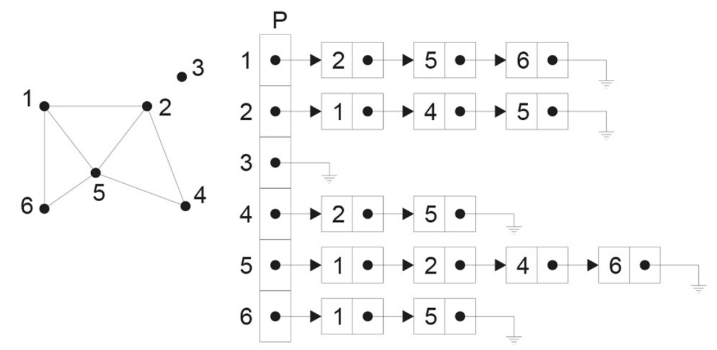

Neste caso, vamos precisar implementar algumas classes especiais **Node** e **Edge**.

In [40]:
class GraphAdjList(GraphBase):

  class Node(object):
    """ Definition of node
    ...

    Attributes
    ----------
    value : int
        Value of node
    edge : Edge
        Edge which the node represents.
    next : Node
        "Pointer" to next node

    """
    def __init__(self) -> None:
      self.value = None
      self.edge = None
      self.next = None

    def __int__(self) -> int: # para facilitar a comparação e exibição
      return self.value

  class Edge(object):
    def __init__(self):
      self.v1, self.node1 = None, None
      self.v2, self.node2 = None, None

  def __init__(self, n, directed = False, doublyLinkedList = False, iterateOverNode = False):
    super().__init__(n, directed)
    self.L = [None]*(self.n + 1)

    for i in range(1, self.n + 1):
      self.L[i] = GraphAdjList.Node() # head nodes

    self.doublyLinkedList = doublyLinkedList
    self.iterateOverNode = iterateOverNode


  def addEdge(self, v, w):

    def addToList(v, w, e, mode):
      node = GraphAdjList.Node()

      node.value = w
      node.edge = e
      node.next = self.L[v].next
      self.L[v].next = node

      if self.doublyLinkedList:
        self.L[v].next.prev = self.L[v]

        if self.L[v].next.next != None:
          self.L[v].next.next.prev = self.L[v].next

      if self.directed:
        node.mode = mode

      return node

    e = GraphAdjList.Edge()
    e.v1, e.v2 = v, w

    e.node1 = addToList(v, w, e, "+")
    e.node2 = addToList(w, v, e, "-")

    self.m += 1

  def removeEdge(self, e):
    def removeFromList(node):
      node.prev.next = node.next
      if node.next != None:
        node.next.prev = node.prev

    removeFromList(e.node1)
    removeFromList(e.node2)

    self.m -= 1

  def getNeighbors(self, v: int, mode: str = "*", closed: bool = False):
    if closed:
      node = GraphAdjList.Node()
      node.value = v

      yield node if self.iterateOverNode else v

    node = self.L[v].next

    while node != None:
      if self.directed:
        if mode == "*" or node.mode == mode:
          yield node if self.iterateOverNode else node.value
      else:
        yield node if self.iterateOverNode else node.value

      node = node.next


  def isNeighbor(self, v, w):
    mode = "+" if self.directed else "*"

    for node in self.getNeighbors(v, mode):
      if node.value == w:
        return True

    return False


In [41]:
G_m = GraphAdjList(n = 5, directed = True, doublyLinkedList = False)
G_m.addEdge(1, 2)
G_m.addEdge(1, 3)
G_m.addEdge(2, 3)
G_m.addEdge(2, 4)
G_m.addEdge(3, 4)

for w in G_m.getNeighbors(2, "-"):
  print(w)

1
